# Tutorial - Language Translation with Word Level seq2seq Transformers
The objective is to convert a German sentence (sequence of words) to English using a Neural Machine Translation (NMT) system based on word level encoder-decoder models.

<img src="https://i.imgur.com/So32H7U.png">

We will use German-English sentence pairs data from http://www.manythings.org/anki/

Sequence-to-Sequence (seq2seq) models are used for a variety of NLP tasks, such as text summarization, speech recognition, language translation, text-to-speech, speech-to-text among others. Our aim is to translate german to english sentences.

Here, both, the input and output are sentences. In other words, these sentences are a sequence of words going in and out of our model.

<img src="https://i.imgur.com/Uk1tCPo.png">

A typical seq2seq model is also known as an encoder-decoder model and has 2 major components:

+ The encoder
+ The decoder


<img src="https://i.imgur.com/bT6PAtv.png">

## SimpleTransformers

Here we will use the excellent SimpleTransformers framework which is a wrapper on top of the already popular transformers framework from HuggingFace.

SimpleTransformers enables us to focus on the core workflow and task at hand, taking out the heavy lifting of data formatting and writing unnecessary boilerplate code

In [ ]:
!pip install simpletransformers

     |████████████████████████████████| 231 kB 5.0 MB/s 
     |████████████████████████████████| 3.3 MB 51.8 MB/s 
     |████████████████████████████████| 1.2 MB 53.5 MB/s 
     |████████████████████████████████| 8.3 MB 27.0 MB/s 
     |████████████████████████████████| 43 kB 2.9 MB/s 
     |████████████████████████████████| 270 kB 68.2 MB/s 
     |████████████████████████████████| 2.9 MB 74.3 MB/s 
     |████████████████████████████████| 1.7 MB 57.2 MB/s 
     |████████████████████████████████| 56 kB 6.8 MB/s 
     |████████████████████████████████| 895 kB 60.7 MB/s 
     |████████████████████████████████| 636 kB 78.3 MB/s 
     |████████████████████████████████| 139 kB 78.0 MB/s 
     |████████████████████████████████| 180 kB 61.2 MB/s 
     |████████████████████████████████| 97 kB 10.0 MB/s 
     |████████████████████████████████| 63 kB 2.6 MB/s 
     |████████████████████████████████| 1.3 MB 67.4 MB/s 
     |████████████████████████████████| 243 kB 62.5 MB/s 
     |████████████████

## Download Dataset

In [ ]:
!wget http://www.manythings.org/anki/deu-eng.zip
!unzip deu-eng.zip
!ls -l

--2021-10-07 05:36:01--  http://www.manythings.org/anki/deu-eng.zip
Resolving www.manythings.org (www.manythings.org)... 104.21.92.44, 172.67.186.54, 2606:4700:3030::6815:5c2c, ...
Connecting to www.manythings.org (www.manythings.org)|104.21.92.44|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9079830 (8.7M) [application/zip]
Saving to: ‘deu-eng.zip’

deu-eng.zip         100%[===================>]   8.66M  44.6MB/s    in 0.2s    

2021-10-07 05:36:02 (44.6 MB/s) - ‘deu-eng.zip’ saved [9079830/9079830]

Archive:  deu-eng.zip
  inflating: deu.txt                 
  inflating: _about.txt              
total 45680
-rw-r--r-- 1 root root     1441 Jul 14 10:16 _about.txt
-rw-r--r-- 1 root root  9079830 Jul 14 01:16 deu-eng.zip
-rw-r--r-- 1 root root 37686235 Jul 14 10:16 deu.txt
drwxr-xr-x 1 root root     4096 Sep 30 17:12 sample_data


## Load Dataset

In [ ]:
import numpy as np

FILE_NAME = './deu.txt'
with open(FILE_NAME, mode='rt', encoding='utf-8') as infile:
  data = infile.read()
  sentences = data.strip().split('\n')
  sentences = [item.split('\t') for item in sentences]
  eng_deu = np.array(sentences)

eng_deu = eng_deu[:10000]
eng_deu

array([['Go.', 'Geh.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2877272 (CM) & #8597805 (Roujin)'],
       ['Hi.', 'Hallo!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)'],
       ['Hi.', 'Grüß Gott!',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)'],
       ...,
       ["That's my bike.", 'Das ist mein Fahrrad.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2251091 (CK) & #445924 (MUIRIEL)'],
       ["That's my book.", 'Das ist mein Buch.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #2780935 (CK) & #1002794 (Esperantostern)'],
       ["That's my doll.", 'Das ist meine Puppe.',
        'CC-BY 2.0 (France) Attribution: tatoeba.org #1897795 (CK) & #1907069 (Pfirsichbaeumchen)']],
      dtype='<U537')

In [ ]:
deu = eng_deu[:,1]
eng = eng_deu[:,0]
eng, deu

(array(['Go.', 'Hi.', 'Hi.', ..., "That's my bike.", "That's my book.",
        "That's my doll."], dtype='<U537'),
 array(['Geh.', 'Hallo!', 'Grüß Gott!', ..., 'Das ist mein Fahrrad.',
        'Das ist mein Buch.', 'Das ist meine Puppe.'], dtype='<U537'))

## Basic Preprocessing

In [ ]:
import string

# Remove punctuation and lowercase
eng = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in eng])
deu = np.array([s.translate(str.maketrans('', '', string.punctuation)).lower() for s in deu])
eng, deu

(array(['go', 'hi', 'hi', ..., 'thats my bike', 'thats my book',
        'thats my doll'], dtype='<U14'),
 array(['geh', 'hallo', 'grüß gott', ..., 'das ist mein fahrrad',
        'das ist mein buch', 'das ist meine puppe'], dtype='<U48'))

## Analyze Sentences

In [ ]:
eng_len = [len(s.split()) for s in eng]
deu_len = [len(s.split()) for s in deu]

max(eng_len), max(deu_len)

(5, 9)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9b1191d890>,
      dtype=object)

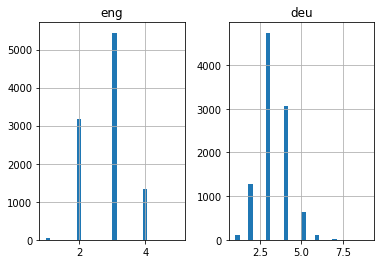

In [ ]:
import pandas as pd
%matplotlib inline

length_df = pd.DataFrame({'eng':eng_len, 'deu':deu_len})
length_df.hist(bins=30)

## Prepare Train Test Splits

In [ ]:
from sklearn.model_selection import train_test_split

train_deu, test_deu, train_eng, test_eng = train_test_split(deu, eng, test_size=0.2, random_state = 42)
train_deu.shape, test_deu.shape, train_eng.shape, test_eng.shape

((8000,), (2000,), (8000,), (2000,))

## Load Pretrained Facebook-BART Model
>Denoising Sequence-to-Sequence Pre-training for Natural Language Generation, Translation, and Comprehension

### Abstract from paper:
We present BART, a denoising autoencoder for pretraining sequence-to-sequence models. BART is trained by :
+ (1) corrupting text with an arbitrary noising function, and
+ (2) learning a model to reconstruct the original text.

It uses a standard Tranformer-based neural machine translation architecture which, despite its simplicity, can be seen as generalizing BERT (due to the bidirectional encoder), GPT (with the left-to-right decoder), and other recent pre- training schemes.

<p align="center">
<img src="https://i.imgur.com/mDlYVqB.png" >
</p>

BART for Language Translation trains two disjoint encoders for the respective languages

__Arxiv Link :[BART](https://arxiv.org/abs/1910.13461)__



In [ ]:
import logging
from simpletransformers.seq2seq import Seq2SeqModel,Seq2SeqArgs

logging.basicConfig(level=logging.INFO)
transformers_logger = logging.getLogger("transformers")
transformers_logger.setLevel(logging.WARNING)

### Setup Model Arguments

In [ ]:
model_args = Seq2SeqArgs()
model_args.num_train_epochs = 5
model_args.no_save = True
model_args.train_batch_size = 16
model_args.evaluate_generated_text = True
model_args.evaluate_during_training = True
model_args.evaluate_during_training_verbose = True
model_args.overwrite_output_dir = True


In [ ]:
print(model_args)

Seq2SeqArgs(adafactor_beta1=None, adafactor_clip_threshold=1.0, adafactor_decay_rate=-0.8, adafactor_eps=(1e-30, 0.001), adafactor_relative_step=True, adafactor_scale_parameter=True, adafactor_warmup_init=True, adam_epsilon=1e-08, best_model_dir='outputs/best_model', cache_dir='cache_dir/', config={}, cosine_schedule_num_cycles=0.5, custom_layer_parameters=[], custom_parameter_groups=[], dataloader_num_workers=0, do_lower_case=False, dynamic_quantize=False, early_stopping_consider_epochs=False, early_stopping_delta=0, early_stopping_metric='eval_loss', early_stopping_metric_minimize=True, early_stopping_patience=3, encoding=None, eval_batch_size=8, evaluate_during_training=True, evaluate_during_training_silent=True, evaluate_during_training_steps=2000, evaluate_during_training_verbose=True, evaluate_each_epoch=True, fp16=True, gradient_accumulation_steps=1, learning_rate=4e-05, local_rank=-1, logging_steps=50, loss_type=None, loss_args={}, manual_seed=None, max_grad_norm=1.0, max_seq_l

### Initialize Model

In [ ]:
# Initialize model
model = Seq2SeqModel(
    encoder_decoder_type="bart",
    encoder_decoder_name="facebook/bart-base",
    args=model_args,
    use_cuda=True,
)

Downloading:   0%|          | 0.00/1.65k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/532M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/878k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/446k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.29M [00:00<?, ?B/s]

### Fine-tune the Model

In [ ]:
train_df = pd.DataFrame(data={
    "input_text":train_deu,
    "target_text":train_eng
    })

In [ ]:
test_df = pd.DataFrame(data={
    "input_text":test_deu,
    "target_text":test_eng
    })

In [ ]:
# Train the model
model.train_model(
    train_df, eval_data=test_df)

INFO:simpletransformers.seq2seq.seq2seq_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/8000 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model: Training started


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Running Epoch 0 of 5:   0%|          | 0/500 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/simpletransformers/seq2seq/seq2seq_model.py:774: FutureWarning: Non-finite norm encountered in torch.nn.utils.clip_grad_norm_; continuing anyway. Note that the default behavior will change in a future release to error out if a non-finite total norm is encountered. At that point, setting error_if_nonfinite=false will be required to retain the old behavior.
  model.parameters(), args.max_grad_norm
/usr/local/lib/python3.7/dist-packages/torch/optim/lr_scheduler.py:134: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
INFO:simple

  0%|          | 0/2000 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:{'eval_loss': 2.110710152387619}
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-500-epoch-1
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/best_model


Running Epoch 1 of 5:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-1000-epoch-2
INFO:simpletransformers.seq2seq.seq2seq_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:{'eval_loss': 1.6529012480974197}
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-1000-epoch-2
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/best_model


Running Epoch 2 of 5:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-1500-epoch-3
INFO:simpletransformers.seq2seq.seq2seq_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:{'eval_loss': 1.4267084077596663}
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-1500-epoch-3
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/best_model


Running Epoch 3 of 5:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-2000
INFO:simpletransformers.seq2seq.seq2seq_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:{'eval_loss': 1.193307114481926}
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-2000
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/best_model
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-2000-epoch-4
INFO:simpletransformers.seq2seq.seq2seq_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:{'eval_loss': 1.193307114481926}
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-2000-epoch-4


Running Epoch 4 of 5:   0%|          | 0/500 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-2500-epoch-5
INFO:simpletransformers.seq2seq.seq2seq_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:{'eval_loss': 1.1595513639450072}
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/checkpoint-2500-epoch-5
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/best_model
INFO:simpletransformers.seq2seq.seq2seq_model:Saving model into outputs/
INFO:simpletransformers.seq2seq.seq2seq_model: Training of facebook/bart-base model complete. Saved to outputs/.


(2500,
 {'eval_loss': [2.110710152387619,
   1.6529012480974197,
   1.4267084077596663,
   1.193307114481926,
   1.193307114481926,
   1.1595513639450072],
  'global_step': [500, 1000, 1500, 2000, 2000, 2500],
  'train_loss': [2.250077486038208,
   1.2497655153274536,
   1.5205267667770386,
   0.9584308862686157,
   0.9584308862686157,
   0.6966242790222168]})

In [ ]:
# Evaluate the model
model_outputs = model.eval_model(test_df)
model_outputs

INFO:simpletransformers.seq2seq.seq2seq_utils: Creating features from dataset file at cache_dir/


  0%|          | 0/2000 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/250 [00:00<?, ?it/s]

Generating outputs:   0%|          | 0/250 [00:00<?, ?it/s]

INFO:simpletransformers.seq2seq.seq2seq_model:{'eval_loss': 1.1595513639450072}


{'eval_loss': 1.1595513639450072}

### Evaluate Model Performance

In [ ]:
# test set
pred_texts = model.predict(train_deu[:100].tolist())

# convert predictions into text (English)
pred_df = pd.DataFrame({'source': train_deu[:100], 'target' : train_eng[:100], 'predicted' : pred_texts})

Generating outputs:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,ich bin ziemlich faul,ich werde es tun,es ist klar,ich stimme ganz zu,lass es tom machen,ich hasse französisch,ich gehe gerne zu fuß,sie sind nicht nett,bist du tot,wir alle sterben,ich huste viel,mach die sause,ich werde entscheiden,jetzt fühle ich es,es ist sehr kalt,ich schreie,du irrst dich,lass es bitte,träum schön,wie geht es ihrem vater,ich bin sehr müde,sie braucht dich,es war nicht groß,ich reise viel,verschwinden sie einfach,sie hat mit mir schluss gemacht,schlagen sie tom,du kennst sie,tom malt,nehmen sie davon,tom ist unordentlich,wirklich,ist tom hingegangen,ich gehe nach hause,hören sie auf zu lächeln,tom lachte,segeln macht spaß,ich mag pizza,der sommer ist vorüber,gib mir eine woche,es funktioniert,komm frühzeitig,es ist zu hause,das ist eine fälschung,ich habe auch geweint,er wurde verrückt,mir ist auch langweilig,ich wurde böse,wir haben es verloren,wir werden ausgehen
target,im quite lazy,ill do it,its clear,i quite agree,let tom do it,i hate french,i like to walk,youre unkind,are you dead,we all die,i cough a lot,go away,ill decide,i feel it now,its very cold,im screaming,you are wrong,please stop it,sweet dreams,hows your dad,im very tired,she needs you,it wasnt big,i travel a lot,just get lost,she ditched me,hit tom,you know her,tom paints,have some,tom is messy,you dont say,did tom go,im going home,stop smiling,tom laughed,sailing is fun,i like pizza,summer is over,give me a week,its working,come early,its at home,thats a fake,i cried too,he went crazy,im bored too,i got angry,we lost it,well go out
predicted,im quite lazy,ill do it,its clear,i agree,let tom do it,i hate french,i like walking,yourent nice,are you dead,we all die,i cough a lot,go away,ill decide,i feel it now,its very cold,i scream,youre wrong,let it be,sweet dreams,how is it made,im very tired,she needs you,it wasnt big,i travel a lot,just relax,she hit me,look tom,you know her,tom is eating,take that,tom is messy,wiously,did tom go,i go home,stop smiling,tom laughed,seels fun,i like pizza,summer is over,give me a week,it works,come early,its home,thats a fake,i cried too,he was mad,i feel bored,i got angry,we lost it,well go out


In [ ]:
pred_texts = model.predict(test_deu[:100].tolist())

# convert predictions into text (English)
pred_df = pd.DataFrame({'source': test_deu[:100], 'target' : test_eng[:100], 'predicted' : pred_texts})

Generating outputs:   0%|          | 0/13 [00:00<?, ?it/s]

In [ ]:
pred_df.head(50).T

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,40,41,42,43,44,45,46,47,48,49
source,ich zeigs dir,sie entkamen,schau nach vorne,das ist fisch,heben sie das auf,ich will es nicht wahrhaben,tom log,was ist das problem,ich bin nicht glücklich,ich stöhnte,es war warm,tom wird sich ändern,sie können nicht gehen,gehen sie hinunter,ich habe diese gemacht,ich liebe meinen vater,thomas spuckte,nimm das zurück,die mädchen haben gesiegt,haben wir eins,zeig ihn ihm,zieh dich um,nimm es runter,es ist wunderbar,tom lenkte ein,halte den zug an,tom ist weg,führen sie mich nicht in versuchung,es ist so still,ich liebe kleine kätzchen,alle aufstehen,ich bin gefangen,hör auf zu schreien,tom gab nach,geh sie suchen,wir sind verärgert,verlieren sie das nicht,komm mit,ich ließ ihn los,kontrolliers einfach,tu es mit mir,entspann dich,er biss sich auf die lippe,ich brauche dich,ist französisch leicht,entschuldigung,tom murrte,du bist krank,iss bitte,er war beschäftigt
target,ill show you,they escaped,look ahead,this is fish,pick that up,im in denial,tom lied,whats wrong,im not happy,i moaned,it was warm,tomll change,you cant go,go downstairs,i made these,i love my dad,tom spit,take that back,the girls won,do we have one,show it to him,get changed,take it down,its marvelous,tom relented,stop the train,toms gone,dont tempt me,its so quiet,i love kittens,all rise,im trapped,stop yelling,tom relented,go look for it,were upset,dont lose it,join us,i let him go,just check it,do it with me,relax,he bit his lip,i need you,is french easy,sorry,tom grumbled,youre sick,please eat,he was busy
predicted,i show you,they fled,look closely,thats fish,do this up,i wont do it,tom is lying,what is it,im not happy,i will obey,it was warm,tom will change,you cant go,go downstairs,i made this,i love my dad,tom giggled,take the jump,they cheered,are we alone,show it to him,go away,take it down,its amazing,tom plead guilty,stop the door,tom is gone,dont push me,its so quiet,i love chess,open up,i have left,stop yelling,tom went out,go try it,were upset,dont lose it,come with me,i love him,just check it,do it to me,just relax,he bit her lip,i need you,is french,just apologize,tom murrried,youre sick,eat please,he was busy


- BLEU score
- ROUGE score